# Step1: A. Clean mock_transactions.csv, Issues: 5% missing AmountSpent, Inconsistent Date formats, Outliers in Quantity

In [38]:
import pandas as pd
import numpy as np

In [39]:
# Load data
df_transactions = pd.read_csv(r"C:\Users\geeze\Downloads\mock_transactions.csv")

# Convert 'Date' column to datetime
df_transactions['Date'] = pd.to_datetime(df_transactions['Date'], errors='coerce')

# Fill missing AmountSpent with median or mean
df_transactions['AmountSpent'].fillna(df_transactions['AmountSpent'].median(), inplace=True)

# Cap Quantity at 99th percentile to remove extreme outliers
q99 = df_transactions['Quantity'].quantile(0.99)
df_transactions['Quantity'] = np.where(df_transactions['Quantity'] > q99, q99, df_transactions['Quantity'])


C:\Users\geeze\AppData\Local\Temp\ipykernel_14976\4200923133.py:8: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_transactions['AmountSpent'].fillna(df_transactions['AmountSpent'].median(), inplace=True)


# B. Clean mock_demographics.csv, Issues: 10% missing IncomeLevel, Inconsistent Gender values

In [40]:
df_demographics = pd.read_csv(r"C:\Users\geeze\Downloads\mock_demographics.csv")

# Normalize gender values
df_demographics['Gender'] = df_demographics['Gender'].str.lower().map({
    'm': 'Male', 'male': 'Male', 'f': 'Female', 'female': 'Female'
})

# Fill missing IncomeLevel with most frequent value (mode)
df_demographics['IncomeLevel'].fillna(df_demographics['IncomeLevel'].mode()[0], inplace=True)


C:\Users\geeze\AppData\Local\Temp\ipykernel_14976\4123959876.py:9: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_demographics['IncomeLevel'].fillna(df_demographics['IncomeLevel'].mode()[0], inplace=True)


# Step 2: Feature Engineering:
# Let’s create features like: Total Spend per Customer, Average Spend, Purchase Frequency

In [41]:
# Merge transaction + demographic
df = pd.merge(df_transactions, df_demographics, on='CustomerID', how='left')

# Aggregate per customer
features = df.groupby('CustomerID').agg({
    'AmountSpent': ['sum', 'mean'],
    'TransactionID': 'count',
    'Quantity': 'mean',
    'Age': 'first',
    'Gender': 'first',
    'IncomeLevel': 'first',
    'LoyaltyMember': 'first'
}).reset_index()

# Rename columns
features.columns = ['CustomerID', 'TotalSpend', 'AvgSpend', 'TransactionCount', 'AvgQuantity', 
                    'Age', 'Gender', 'IncomeLevel', 'LoyaltyMember']


# Step 3: Clustering
# Used K-Means and evaluate using silhouette score.

In [42]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Encode categorical variables
features_encoded = pd.get_dummies(features, columns=['Gender', 'IncomeLevel', 'LoyaltyMember'], drop_first=True)

# Scale numeric features
scaler = StandardScaler()
X = scaler.fit_transform(features_encoded.drop(['CustomerID'], axis=1))

# Try KMeans with 3–6 clusters
scores = {}
for k in range(3, 6):
    km = KMeans(n_clusters=k, random_state=42)
    labels = km.fit_predict(X)
    scores[k] = silhouette_score(X, labels)
    print(f"K={k} → Silhouette Score: {scores[k]:.3f}")

# Fit final model with best K (e.g., K=4)
k_final = max(scores, key=scores.get)
kmeans = KMeans(n_clusters=k_final, random_state=42)
features['Segment'] = kmeans.fit_predict(X)


K=3 → Silhouette Score: 0.155
K=4 → Silhouette Score: 0.148
K=5 → Silhouette Score: 0.139


# EDA Process






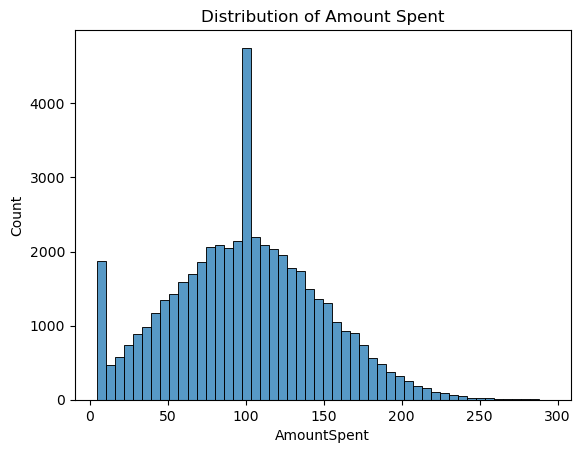

In [43]:
import seaborn as sns
import matplotlib.pyplot as plt

# Distribution of AmountSpent
sns.histplot(df_transactions['AmountSpent'], bins=50) # type: ignore
plt.title("Distribution of Amount Spent")
plt.show()


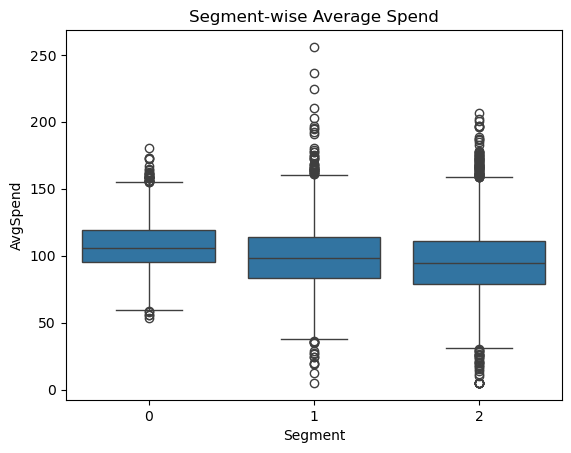

In [44]:
# Customer Segment vs Avg Spend
sns.boxplot(x='Segment', y='AvgSpend', data=features) # type: ignore
plt.title("Segment-wise Average Spend")
plt.show()

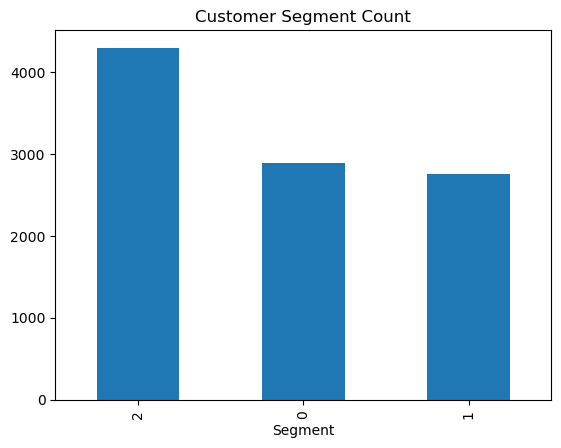

In [45]:
# Segment Size
features['Segment'].value_counts().plot(kind='bar', title='Customer Segment Count') # type: ignore
plt.show()


In [46]:
# Export final feature set to CSV
features.to_csv("segmented_customers.csv", index=False)


In [ ]:
# Saving datasets for Excel + SQL + Tableau
features.to_csv("segmented_customers.csv", index=False)
df_transactions.to_csv("clean_transactions.csv", index=False)
df_demographics.to_csv("clean_demographics.csv", index=False)
df_stores.to_csv("clean_stores.csv", index=False) 